# Artificial data testing of SINDy
Using some artificial data that I generated to try to test the boundary of SINDy. From this experimentation I found that a sine wave with a constant value added to it will fit perfectly fine. Problems occur when a gradient proportional to the distance along the cable is introduced.

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from sklearn.metrics import r2_score
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary

# import cv2

# matplotlib.use('TkAgg')
%matplotlib inline

# Set up data

In [2]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [3]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [4]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = datetime.datetime(2023,8,9)
end_time = datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [5]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)

startt = datetime.datetime(2023, 8, 25, 16) # 25
endt = datetime.datetime(2023, 8, 25, 18) # 25
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

# startind_d = np.absolute(plot_dists - 2940).argmin()
# endind_d = np.absolute(plot_dists - 3000).argmin()

startind_d = np.absolute(plot_dists - 2900).argmin()
endind_d = np.absolute(plot_dists - 3300).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

# Detecting the amplitude of the waves

## Making my own contours

In [6]:
contour_values = np.linspace(0.55, 2.2, 100) # 0.55
contour_values_legend = []
for i in range(len(contour_values)): contour_values_legend.append(str(contour_values[i]) + "ºC")

contour_points = {}
contour_points_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
# np.empty((len(contour_values), len(filtered_arr[:, 1])))
nan_inds = {}
real_inds = {}
depths_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
cvi = 0

for cv in contour_values:
    avg_zero_crossings = 0
    nan_inds[cvi] = []
    real_inds[cvi] = []
    contour_points[cv] = {}
    contour_points[cv]['x'] = []
    contour_points[cv]['t'] = []
    for i in range(len(filtered_arr[:, 0])):
        xc = pyaC.zerocross1d(plot_dists_zoomed, filtered_arr[i, :] - cv)
        if(len(xc) == 1):
            real_inds[cvi].append(i)
            contour_points_arr[cvi, i] = xc.flatten().tolist()[0]
            contour_points[cv]['x'].extend(xc.flatten().tolist())
            contour_points[cv]['t'].extend(np.full(len(xc), plot_times_zoomed_int[i]).tolist())
        else:
            nan_inds[cvi].append(i)
            contour_points_arr[cvi, i] = float('NaN')
        avg_zero_crossings = avg_zero_crossings + len(xc)
    # print('Temp contour =', cv, 'avg of', avg_zero_crossings/len(filtered_arr[:, 0]), 'zero crossings')
    
    nan_inds[cvi] = np.array(nan_inds[cvi])
    real_inds[cvi] = np.array(real_inds[cvi])

    cvi = cvi + 1

contour_points_arr_interp = np.empty( (100, len(plot_times_zoomed)) )
depths = np.nanmedian(contour_points_arr, axis=1)
depths_interp = np.linspace(plot_dists_zoomed[0], plot_dists_zoomed[-1], len(contour_points_arr_interp[:, 0]))

for i in range(len(contour_points_arr[0, :])):
    real_inds = np.where(~np.isnan(contour_points_arr[:, i]))[0]
    contour_points_arr_interp[:, i] = np.interp(depths_interp, depths[real_inds], contour_points_arr[real_inds, i])

# np.interp(xc, plot_dists_zoomed, filtered_arr[i, :])

## Plotting

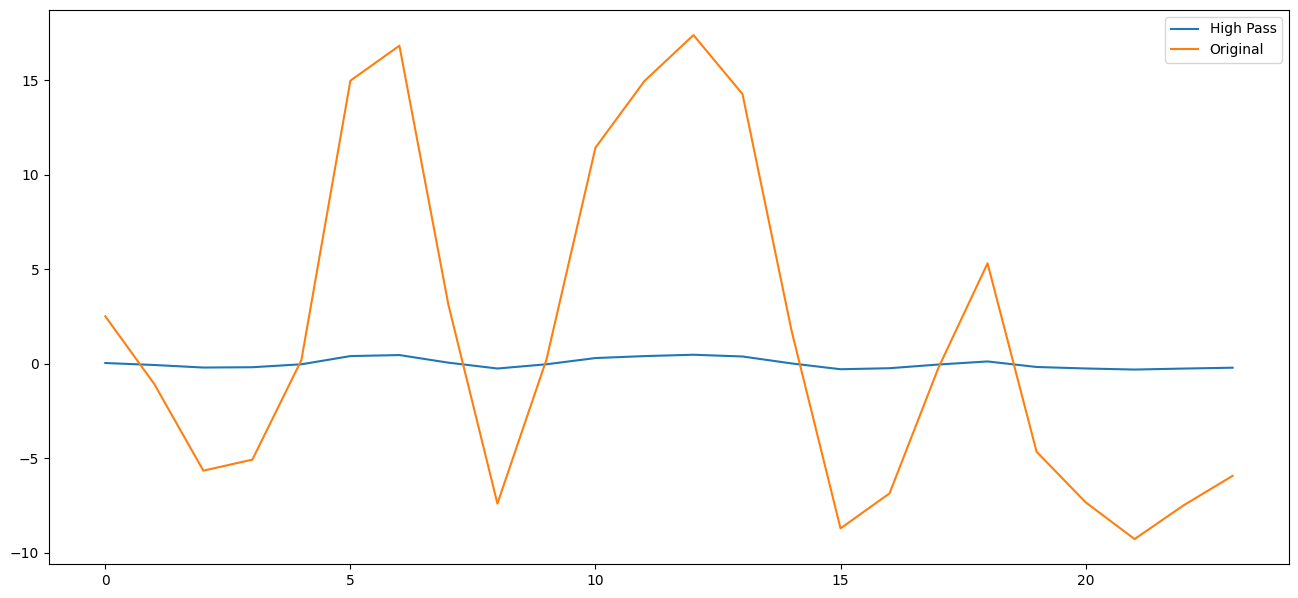

In [7]:
depths = np.empty(np.shape(contour_points_arr_interp))
displacements = np.empty(np.shape(contour_points_arr_interp))

filter = scipy.signal.butter(1, 0.5, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate. Used to be 0.5 cutoff

for i in range(len(contour_points_arr_interp[:, 0])):
    depths[i, :] = depths_interp[i]
    # High pass filter each channel
    # contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))
    displacements[i, :] = contour_points_arr_interp[i, :] - np.mean(contour_points_arr_interp[i, :])
    # displacements[i, :] = contours_high_pass #contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :])   #  contours_high_pass

# displacements = contour_points_arr_interp - np.median(contour_points_arr_interp)
## Normalize displacements ## 
displacements = (displacements - np.min(displacements)) / (np.max(displacements) - np.min(displacements))
displacements = 2 * displacements - 1

i = 60 # np.absolute(depths - 3027).argmin()
contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(displacements[i, :])
ax.plot(contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))
# ax.plot(contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))
ax.legend(['High Pass', 'Original'])

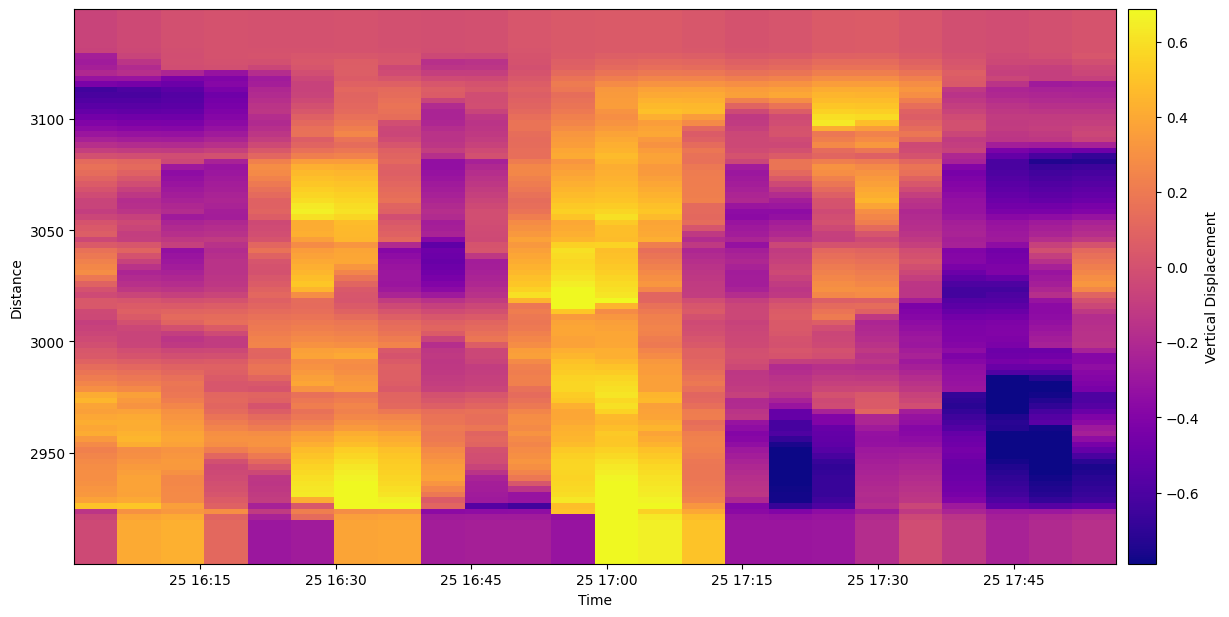

In [8]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(displacements[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + displacements[i, :])
ddt = np.gradient(displacements, axis=1)
im1 = ax.imshow(displacements, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(displacements[~np.isnan(displacements)],1),
            vmax=np.percentile(displacements[~np.isnan(displacements)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


## Temperature plotted data and slice of disps

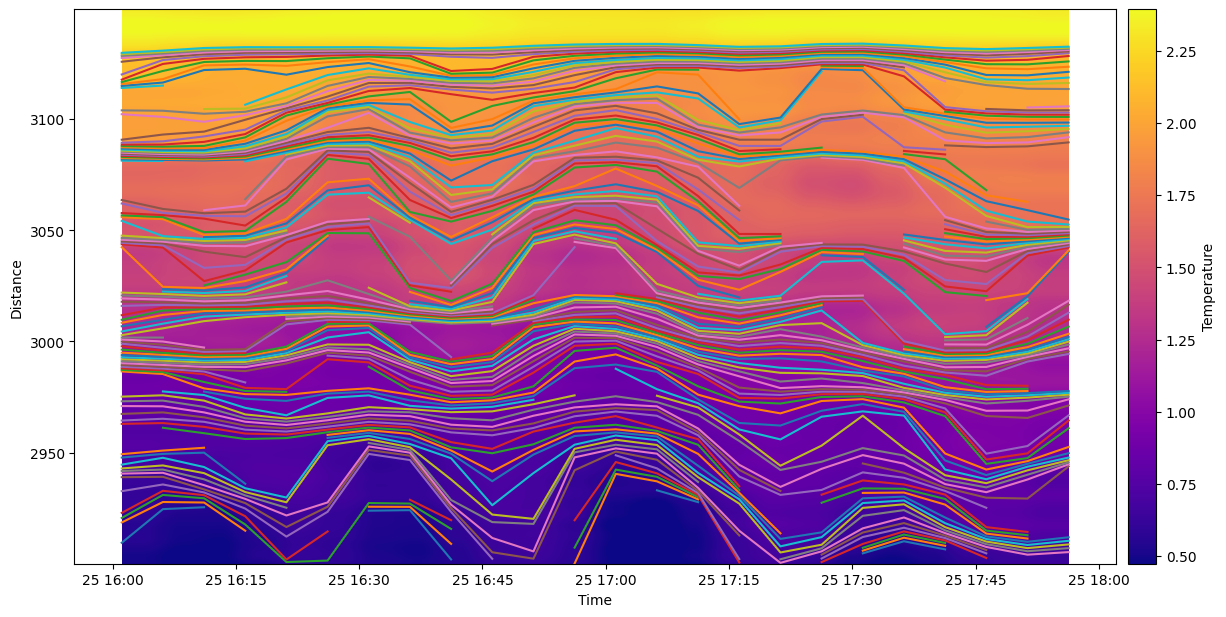

In [240]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
for i in range(len(contour_values)): plt.plot(plot_times_zoomed, contour_points_arr[i], '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

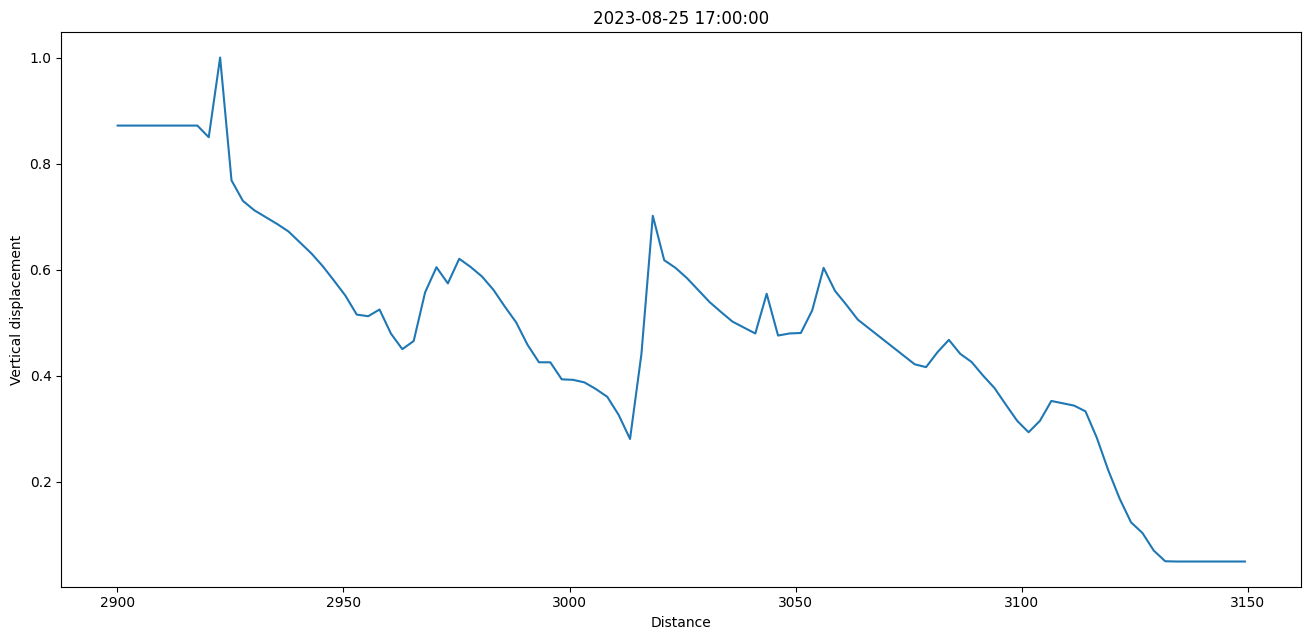

In [10]:
time_slice = datetime.datetime(2023, 8, 25, 17)
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(depths[:, np.absolute(plot_times_zoomed - time_slice).argmin()], displacements[:, np.absolute(plot_times_zoomed - time_slice).argmin()])
ax.set_xlabel('Distance')
ax.set_ylabel('Vertical displacement')
ax.set_title(str(time_slice))
plt.show()

# Set up SINDy

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## SINDy Stuff

## Trying with original method (not weak)

In [234]:
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths[:, 0] - depths[0, 0] # grid_y[0, :]
dt = t[1] - t[0]
dx = x[1] - x[0]
T, X = np.meshgrid(t, x)

displacements = np.sin(T/5) + X * 5e-2 + np.random.randn(len(x), len(t)) * 2e-1

u_sol = displacements
v_sol = ps.SmoothedFiniteDifference(axis=1)._differentiate(u_sol, t=dt)

u = np.zeros((len(x), len(t), 2))
u[:, :, 0] = u_sol
u[:, :, 1] = v_sol
u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

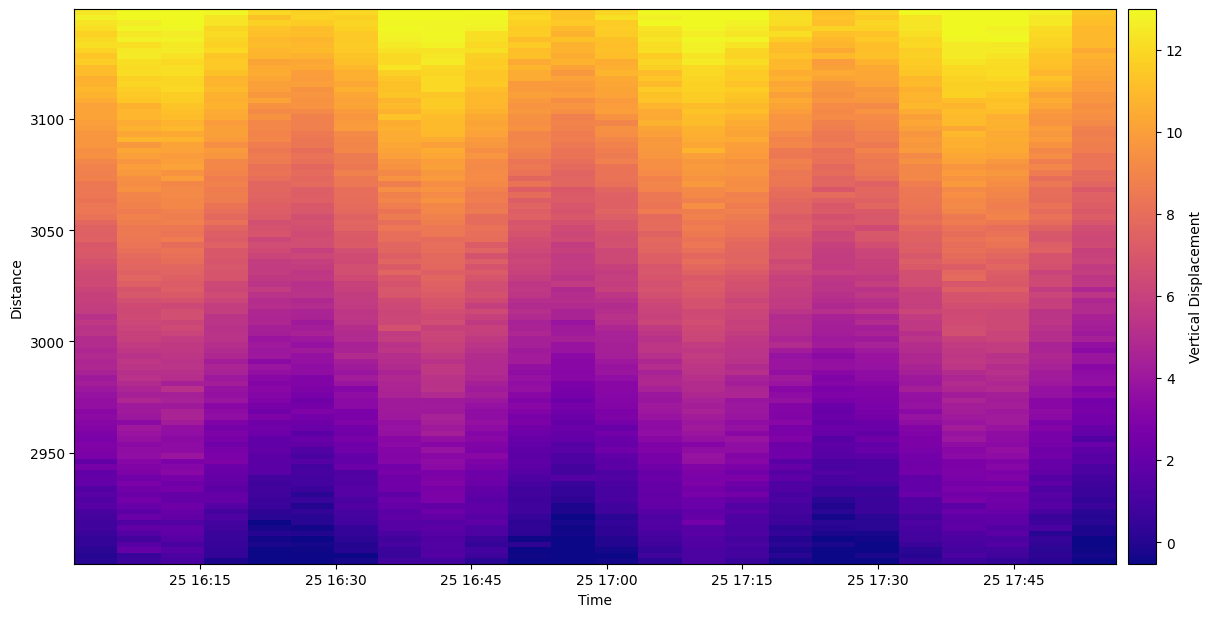

In [235]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(displacements[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + displacements[i, :])
ddt = np.gradient(u[:, :, 0], axis=1)
im1 = ax.imshow(u[:, :, 0], origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(displacements[~np.isnan(displacements)],1),
            vmax=np.percentile(displacements[~np.isnan(displacements)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


In [236]:
train = range(0, int(len(t) * 0.6))
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train, :]
u_test = u[:, test, :]
u_dot_train = u_dot[:, train, :]
u_dot_test = u_dot[:, test, :]
t_train = t[train]
t_test = t[test]

library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)
print(x.shape, u_dot_train.shape, u_dot_test.shape, t_train.shape, t_test.shape)

print('STLSQ model')
optimizer = ps.STLSQ(
    threshold=10e-4,
    max_iter=100000,
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train, ensemble=True, n_models=1000, quiet=True)
model.print()
u_dot_sr3 = model.predict(u_test)

(100,) (100, 14, 2) (100, 10, 2) (14,) (10,)
STLSQ model
(x0)' = 1.000 x1
(x1)' = 0.004 1 + -0.001 x0 + 0.023 x1 + -1.824 x1x1x1 + 0.005 x0x1x1 + -0.014 x0_1 + 0.001 x0_11 + -0.455 x1_11 + 0.004 x0x0_1 + 1.013 x1x1_1 + -0.047 x0x0x0x0_1 + 0.014 x1x1x1x0_1 + -0.213 x1x1x1x1_1


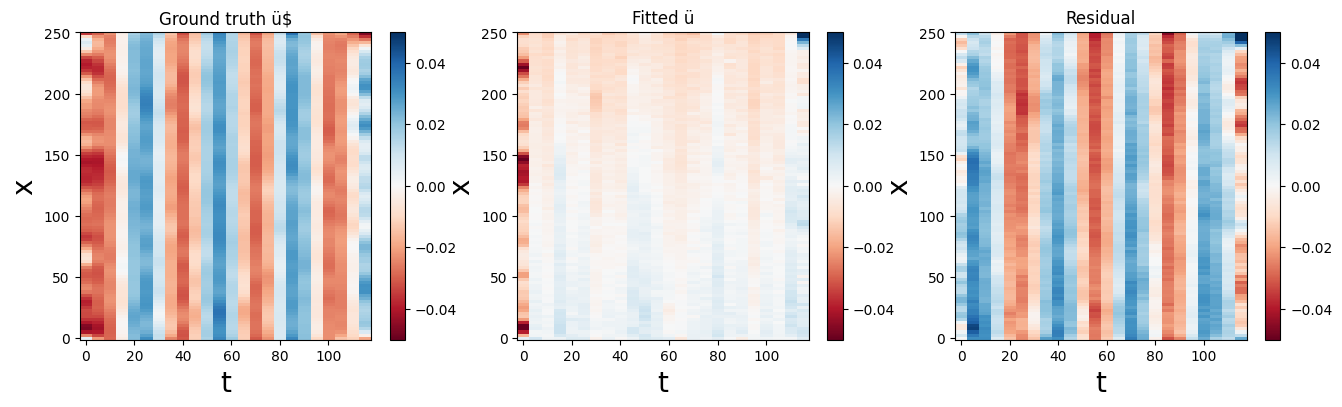

In [238]:
u_dot_pred = model.predict(u)
model_num = 1
min = -0.05
max = 0.05
# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# plt.pcolormesh(t_test, x, u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot[:, :, 1], vmin=min, vmax=max, shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Ground truth ü$')
ax = plt.gca()


plt.subplot(1, 3, 2)
# u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
# plt.pcolormesh(t_test, x, u_dot_stlsq, vmin=-1.5, vmax=1.5)
# u_dot_stlsq = np.reshape(u_dot_sr3, (len(x), len(t_test), 1))
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num], vmin=min, vmax=max, shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Fitted ü')
ax = plt.gca()

plt.subplot(1, 3, 3)
# plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num] - u_dot[:,:,model_num], vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

plt.show()

## Weak formulation

In [225]:
# Example data (replace with your actual data)
train_ind = -1
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths[:, 0] - depths[0, 0] # grid_y[0, :]
dt = t[1] - t[0]
dx = x[1] - x[0]

u_sol = displacements


u = np.zeros((len(x), len(t), 1))
u[:, :, 0] = u_sol
u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

ux = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0)._differentiate(u, dx)


In [226]:
# Define PDE library that is quadratic in u, and 
# third-order in spatial derivatives of u.
spatiotemporal_grid=np.zeros((len(x),len(t),2))
spatiotemporal_grid[:,:,0]=x[:,np.newaxis]
spatiotemporal_grid[:,:,1]=t[np.newaxis,:]

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
np.random.seed(1)

In [239]:
multiindices=np.array([[0,1],[0,2],[1,0],[2,0]])
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=2, spatial_grid=x, temporal_grid=t,
                        include_bias=True, is_uniform=True,implicit_terms=True, multiindices=multiindices)

sindy_opt = ps.SINDyPI(
    threshold=3e-3, max_iter=1000, tol=1e-10,
    thresholder='l1', normalize_columns=False
)
model = ps.SINDy(feature_library=pde_lib, optimizer=sindy_opt)
model.fit(u, t=dt)
model.print()
# print('score', model.score(u,t=dt))

Model  0
Solver failed on model  0 , setting coefs to zeros
Model  1
Solver failed on model  1 , setting coefs to zeros
Model  2
Solver failed on model  2 , setting coefs to zeros
Model  3
Model  4


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 3, try changing your library
  warnings.warn(


Solver failed on model  4 , setting coefs to zeros
Model  5
Solver failed on model  5 , setting coefs to zeros
Model  6
Solver failed on model  6 , setting coefs to zeros
Model  7
Solver failed on model  7 , setting coefs to zeros
Model  8
Solver failed on model  8 , setting coefs to zeros
Model  9
Solver failed on model  9 , setting coefs to zeros
Model  10
Model  11
Solver failed on model  11 , setting coefs to zeros
Model  12
Solver failed on model  12 , setting coefs to zeros
Model  13
Solver failed on model  13 , setting coefs to zeros
Model  14
Solver failed on model  14 , setting coefs to zeros
Model  15
Solver failed on model  15 , setting coefs to zeros
Model  16
Solver failed on model  16 , setting coefs to zeros
Model  17
Solver failed on model  17 , setting coefs to zeros
Model  18
Solver failed on model  18 , setting coefs to zeros
Model  19
Solver failed on model  19 , setting coefs to zeros
Model  20
Solver failed on model  20 , setting coefs to zeros
Model  21
Solver fa

/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Model  37
Solver failed on model  37 , setting coefs to zeros
Model  38
Solver failed on model  38 , setting coefs to zeros
Model  39
Solver failed on model  39 , setting coefs to zeros
Model  40
Solver failed on model  40 , setting coefs to zeros
Model  41
Solver failed on model  41 , setting coefs to zeros
Model  42
Solver failed on model  42 , setting coefs to zeros
Model  43
Model  44
Solver failed on model  44 , setting coefs to zeros
Model  45
Solver failed on model  45 , setting coefs to zeros
Model  46
Solver failed on model  46 , setting coefs to zeros
Model  47
Solver failed on model  47 , setting coefs to zeros
Model  48
Solver failed on model  48 , setting coefs to zeros
Model  49
Model  50
Solver failed on model  50 , setting coefs to zeros
Model  51
Solver failed on model  51 , setting coefs to zeros
Model  52
Solver failed on model  52 , setting coefs to zeros
Model  53
Solver failed on model  53 , setting coefs to zeros
Model  54
Solver failed on model  54 , setting coe

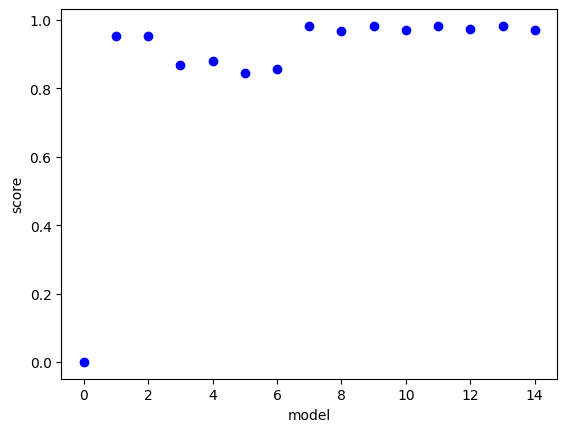

x0x0_tt=-0.015 1 + 0.003 x0 + 0.043 x0_t + 2.318 x0_tt + -0.088 x0_1 + -0.192 x0_11 + -0.022 x0x0_t + 0.002 x0x0x0_t + 0.075 x0x0x0_tt + 0.010 x0x0_1 + 0.102 x0x0_11 + -0.008 x0x0x0_11, score=0.9825900916788334
x0x0_1=-0.105 1 + 0.047 x0 + -0.003 x0x0 + 0.007 x0_t + -0.328 x0_tt + 2.230 x0_1 + 0.659 x0_11 + -0.005 x0x0_t + 0.043 x0x0_tt + 0.001 x0x0x0_tt + 0.072 x0x0x0_1 + -0.129 x0x0_11 + 0.003 x0x0x0_11, score=0.9824403645744562
x0x0_11=-0.067 1 + 0.015 x0 + -0.001 x0x0 + -0.041 x0_t + -1.346 x0_tt + 1.048 x0_1 + 2.227 x0_11 + 0.025 x0x0_t + -0.002 x0x0x0_t + 0.675 x0x0_tt + -0.051 x0x0x0_tt + -0.192 x0x0_1 + 0.004 x0x0x0_1 + 0.072 x0x0x0_11, score=0.9814475305294981
x0x0_t=0.012 1 + -0.005 x0 + 2.265 x0_t + 0.605 x0_tt + 0.024 x0_1 + -0.089 x0_11 + 0.076 x0x0x0_t + -0.319 x0x0_tt + 0.024 x0x0x0_tt + -0.016 x0x0_1 + 0.001 x0x0x0_1 + 0.054 x0x0_11 + -0.004 x0x0x0_11, score=0.9810056105562702
x0x0x0_1=1.064 1 + -0.598 x0 + 0.047 x0x0 + -0.062 x0_t + 2.284 x0_tt + -22.820 x0_1 + -5.978 

In [228]:
lhs_actual=pde_lib.transform(u)
lhs_predict=model.predict(u)


scores=[r2_score(np.reshape(lhs_actual[:,:,ind],(np.product(lhs_actual.shape[:-1]))),np.reshape(lhs_predict[:,:,ind],(np.product(lhs_actual.shape[:-1])))) for ind in range(lhs_predict.shape[-1])]

plt.plot(scores,'bo')
plt.xlabel('model')
plt.ylabel('score')
plt.show()

order=np.argsort(scores)
for ind in np.flip(order[-5:]):
    print(pde_lib.get_feature_names()[ind] + '=' + model.equations()[ind] + ', score=' +str(scores[ind]))

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_79482/3953666501.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Ground truth $\dot{u}$')
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_79482/3953666501.py:25: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Fitted $\dot{u}$')


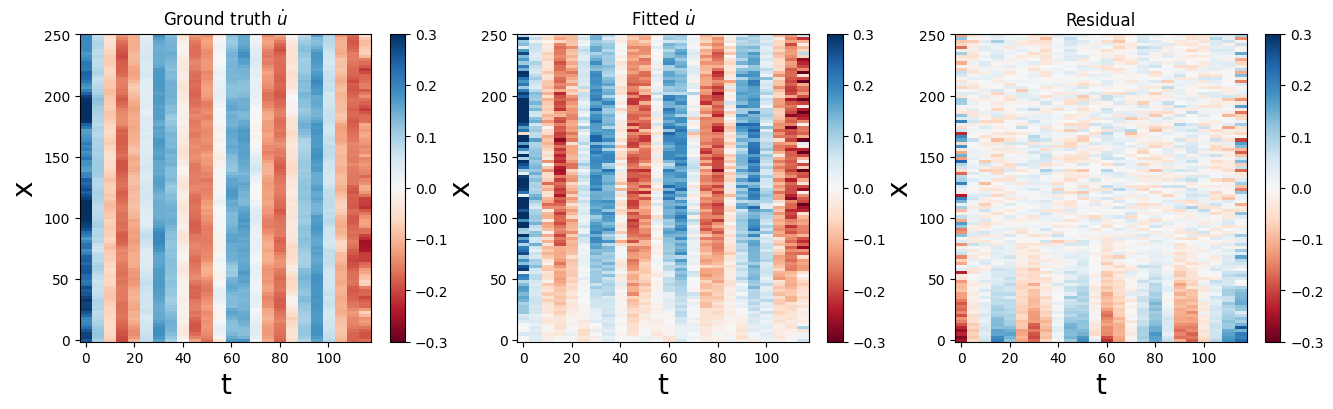

In [229]:
u_dot_pred = model.predict(u)
model_num = 3
# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# plt.pcolormesh(t_test, x, u_dot_test, vmin=-1.5, vmax=1.5)
minextent = -0.3
maxextent = 0.3
plt.pcolormesh(t, x, u_dot[:, :, 0], shading='nearest', vmin=minextent, vmax=maxextent, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Ground truth $\dot{u}$')
ax = plt.gca()


plt.subplot(1, 3, 2)
# u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
# plt.pcolormesh(t_test, x, u_dot_stlsq, vmin=-1.5, vmax=1.5)
# u_dot_stlsq = np.reshape(u_dot_sr3, (len(x), len(t_test), 1))
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num], vmin=minextent, vmax=maxextent, shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Fitted $\dot{u}$')
ax = plt.gca()

plt.subplot(1, 3, 3)
# plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num] - u_dot[:,:,0], vmin=minextent, vmax=maxextent, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

plt.show()